In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
%%writefile embed.py
"""Generate a diffusion map embedding
"""

def compute_diffusion_map(L, alpha=0.5, n_components=None, diffusion_time=0,
                          skip_checks=False, overwrite=False):
    """Compute the diffusion maps of a symmetric similarity matrix

        L : matrix N x N
           L is symmetric and L(x, y) >= 0

        alpha: float [0, 1]
            Setting alpha=1 and the diffusion operator approximates the
            Laplace-Beltrami operator. We then recover the Riemannian geometry
            of the data set regardless of the distribution of the points. To
            describe the long-term behavior of the point distribution of a
            system of stochastic differential equations, we can use alpha=0.5
            and the resulting Markov chain approximates the Fokker-Planck
            diffusion. With alpha=0, it reduces to the classical graph Laplacian
            normalization.

        n_components: int
            The number of diffusion map components to return. Due to the
            spectrum decay of the eigenvalues, only a few terms are necessary to
            achieve a given relative accuracy in the sum M^t.

        diffusion_time: float >= 0
            use the diffusion_time (t) step transition matrix M^t

            t not only serves as a time parameter, but also has the dual role of
            scale parameter. One of the main ideas of diffusion framework is
            that running the chain forward in time (taking larger and larger
            powers of M) reveals the geometric structure of X at larger and
            larger scales (the diffusion process).

            t = 0 empirically provides a reasonable balance from a clustering
            perspective. Specifically, the notion of a cluster in the data set
            is quantified as a region in which the probability of escaping this
            region is low (within a certain time t).

        skip_checks: bool
            Avoid expensive pre-checks on input data. The caller has to make
            sure that input data is valid or results will be undefined.

        overwrite: bool
            Optimize memory usage by re-using input matrix L as scratch space.

        References
        ----------

        [1] https://en.wikipedia.org/wiki/Diffusion_map
        [2] Coifman, R.R.; S. Lafon. (2006). "Diffusion maps". Applied and
        Computational Harmonic Analysis 21: 5-30. doi:10.1016/j.acha.2006.04.006
    """

    import numpy as np
    import scipy.sparse as sps

    use_sparse = False
    if sps.issparse(L):
        use_sparse = True

    if not skip_checks:
        from sklearn.manifold.spectral_embedding_ import _graph_is_connected
        if not _graph_is_connected(L):
            raise ValueError('Graph is disconnected')

    ndim = L.shape[0]
    if overwrite:
        L_alpha = L
    else:
        L_alpha = L.copy()

    if alpha > 0:
        # Step 2
        d = np.array(L_alpha.sum(axis=1)).flatten()
        d_alpha = np.power(d, -alpha)
        if use_sparse:
            L_alpha.data *= d_alpha[L_alpha.indices]
            L_alpha = sps.csr_matrix(L_alpha.transpose().toarray())
            L_alpha.data *= d_alpha[L_alpha.indices]
            L_alpha = sps.csr_matrix(L_alpha.transpose().toarray())
        else:
            L_alpha = d_alpha[:, np.newaxis] * L_alpha 
            L_alpha = L_alpha * d_alpha[np.newaxis, :]

    # Step 3
    d_alpha = np.power(np.array(L_alpha.sum(axis=1)).flatten(), -1)
    if use_sparse:
        L_alpha.data *= d_alpha[L_alpha.indices]
    else:
        L_alpha = d_alpha[:, np.newaxis] * L_alpha

    M = L_alpha

    from scipy.sparse.linalg import eigsh, eigs

    # Step 4
    func = eigs
    if n_components is not None:
        lambdas, vectors = func(M, k=n_components + 1)
    else:
        lambdas, vectors = func(M, k=max(2, int(np.sqrt(ndim))))
    del M

    if func == eigsh:
        lambdas = lambdas[::-1]
        vectors = vectors[:, ::-1]
    else:
        lambdas = np.real(lambdas)
        vectors = np.real(vectors)
        lambda_idx = np.argsort(lambdas)[::-1]
        lambdas = lambdas[lambda_idx]
        vectors = vectors[:, lambda_idx]

    # Step 5
    psi = vectors/vectors[:, [0]]
    if diffusion_time == 0:
        lambdas = lambdas[1:] / (1 - lambdas[1:])
    else:
        lambdas = lambdas[1:] ** float(diffusion_time)
    lambda_ratio = lambdas/lambdas[0]
    threshold = max(0.05, lambda_ratio[-1])

    n_components_auto = np.amax(np.nonzero(lambda_ratio > threshold)[0])
    n_components_auto = min(n_components_auto, ndim)
    if n_components is None:
        n_components = n_components_auto
    embedding = psi[:, 1:(n_components + 1)] * lambdas[:n_components][None, :]

    result = dict(lambdas=lambdas, vectors=vectors,
                  n_components=n_components, diffusion_time=diffusion_time,
                  n_components_auto=n_components_auto)
    return embedding, result

Overwriting embed.py


In [3]:
from embed import compute_diffusion_map

In [4]:
def compute_affinity(X, method='markov', eps=None):
    import numpy as np
    from sklearn.metrics import pairwise_distances
    D = pairwise_distances(X, metric='euclidean')
    if eps is None:
        k = int(max(2, np.round(D.shape[0] * 0.01)))
        eps = 2 * np.median(np.sort(D, axis=0)[k+1, :])**2
    if method == 'markov':
        affinity_matrix = np.exp(-(D * D) / eps)
    elif method == 'cauchy':
        affinity_matrix = 1./(D * D + eps)
    return affinity_matrix

In [5]:
import numpy as np
from sklearn.manifold import SpectralEmbedding, TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import Normalizer

In [7]:
n=5000
t=np.power(np.sort(np.random.rand(n)), .7)*10
al=.15;bet=.5;
x1=bet * np.exp(al * t) * np.cos(t) + 0.1 * np.random.randn(n)
y1=bet * np.exp(al * t) * np.sin(t) + 0.1 * np.random.randn(n)
X = np.hstack((x1[:, None], y1[:, None]))

### Plot original data with the t parameter corresponding to color

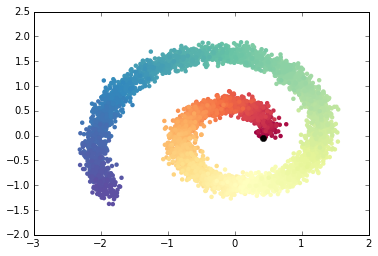

In [8]:
plt.scatter(x1, y1, c=t, cmap=plt.cm.Spectral, linewidths=0)
ph = plt.plot(x1[0], y1[0], 'ko')

In [9]:
L = compute_affinity(X.copy(), method='markov')

In [12]:
import scipy.sparse as sps

In [13]:
%mprun -f compute_diffusion_map compute_diffusion_map(sps.csr_matrix(L))

('',)
